# Embeddings and Chunking with LlamaIndex and Gemini

In this notebook, we explore different chunking techniques and embedding models in LlamaIndex while using Google's Gemini for our language model. We'll learn how different chunking strategies affect retrieval performance and how to use various embedding models.

## Setup and Installation

First, let's install the necessary packages:

In [ ]:
!pip install -q llama-index
!pip install -q llama-index-embeddings-huggingface
!pip install -q llama-index-llms-gemini
!pip install -q llama-index-embeddings-openai
!pip install -q llama-index-vector-stores-chroma
!pip install -q sentence-transformers
!pip install -q chromadb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 69.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.0/208.0 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.0 MB/s eta 0:

Now let's set up our environment:

In [ ]:
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [ ]:
# For Gemini API, set your API key
GOOGLE_API_KEY = ""  # Replace with your actual API key
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## 1. Loading Sample Documents

We'll create a small sample of documents to work with. First, let's create a directory and some sample files:

In [ ]:
!mkdir -p sample_docs

In [ ]:
# Let's create some example documents
with open("sample_docs/ai_history.txt", "w") as f:
    f.write("""Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods and rule-based systems.
In the 1980s, expert systems became popular but faced limitations.
The 1990s and early 2000s saw a shift towards machine learning approaches.
The deep learning revolution began around 2012 with breakthrough results in computer vision.
Today, large language models like GPT, LLaMA, and Gemini represent cutting-edge AI capabilities.
These models are trained on vast amounts of text data and can generate human-like responses.""")

with open("sample_docs/neural_networks.txt", "w") as f:
    f.write("""Neural networks are computing systems inspired by biological neural networks.
The perceptron, developed by Frank Rosenblatt in 1958, was one of the earliest neural network models.
Modern neural networks consist of layers of interconnected nodes or "neurons."
Each connection can transmit a signal from one neuron to another.
The receiving neuron processes the signal and signals downstream neurons connected to it.
Deep neural networks contain multiple hidden layers between input and output layers.
Convolutional Neural Networks (CNNs) revolutionized image processing.
Recurrent Neural Networks (RNNs) and transformers handle sequential data like text or time series.""")

with open("sample_docs/embeddings.txt", "w") as f:
    f.write("""Embeddings are dense vector representations of data in a continuous vector space.
Word embeddings map words to vectors where similar words are positioned closer together.
Popular word embedding techniques include Word2Vec, GloVe, and FastText.
Sentence embeddings capture meaning at the sentence level rather than individual words.
Models like Universal Sentence Encoder and SBERT create powerful sentence embeddings.
Document embeddings represent entire documents as fixed-length vectors.
Embeddings enable semantic search by finding documents with similar meaning, not just keyword matches.
They also power recommendation systems, clustering, and classification tasks.
Recent models like OpenAI's text-embedding-ada and Cohere's embedding models offer state-of-the-art performance.""")

Now let's load these documents using LlamaIndex:

In [ ]:
from llama_index.core import SimpleDirectoryReader

# Load documents
documents = SimpleDirectoryReader("sample_docs").load_data()
print(f"Loaded {len(documents)} documents.")

# Display document contents
for i, doc in enumerate(documents):
    print(f"\n--- Document {i+1}: {doc.metadata['file_name']} ---")
    print(doc.text[:200] + "...")  # Show first 200 chars

Loaded 3 documents.

--- Document 1: ai_history.txt ---
Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods ...

--- Document 2: embeddings.txt ---
Embeddings are dense vector representations of data in a continuous vector space.
Word embeddings map words to vectors where similar words are positioned closer together.
Popular word embedding techni...

--- Document 3: neural_networks.txt ---
Neural networks are computing systems inspired by biological neural networks.
The perceptron, developed by Frank Rosenblatt in 1958, was one of the earliest neural network models.
Modern neural networ...


## 2. Exploring Different Chunking Techniques

Chunking is a critical preprocessing step for using documents with LLMs. Let's explore different chunking strategies:



### 2.1 Fixed-Length Chunking

The simplest approach is to divide text into chunks of a fixed size:

In [ ]:
from llama_index.core.node_parser import SentenceSplitter

# Fixed-length chunking with no overlap
splitter_fixed = SentenceSplitter(chunk_size=100, chunk_overlap=0)
chunks_fixed = splitter_fixed.get_nodes_from_documents(documents)
print(f"Total Fixed-Length Chunks Created: {len(chunks_fixed)}")

# Display a sample chunk
print(f"\nSample fixed-length chunk:")
print(chunks_fixed[0].text)

Total Fixed-Length Chunks Created: 6

Sample fixed-length chunk:
Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods and rule-based systems.
In the 1980s, expert systems became popular but faced limitations.
The 1990s and early 2000s saw a shift towards machine learning approaches.


### 2.2 Overlapping Chunks

Adding overlap between chunks helps maintain context across chunk boundaries:

In [ ]:
# Chunking with overlap
splitter_overlap = SentenceSplitter(chunk_size=100, chunk_overlap=20)
chunks_overlap = splitter_overlap.get_nodes_from_documents(documents)
print(f"Total Overlapping Chunks Created: {len(chunks_overlap)}")

# Display a sample chunk with its neighbor to see overlap
print(f"\nOverlap Example:")
print(f"Chunk 1: {chunks_overlap[0].text}")
print(f"Chunk 2: {chunks_overlap[1].text}")

Total Overlapping Chunks Created: 6

Overlap Example:
Chunk 1: Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods and rule-based systems.
In the 1980s, expert systems became popular but faced limitations.
The 1990s and early 2000s saw a shift towards machine learning approaches.
Chunk 2: The 1990s and early 2000s saw a shift towards machine learning approaches.
The deep learning revolution began around 2012 with breakthrough results in computer vision.
Today, large language models like GPT, LLaMA, and Gemini represent cutting-edge AI capabilities.
These models are trained on vast amounts of text data and can generate human-like responses.


### 2.3 Semantic Chunking

Semantic chunking splits text based on meaning rather than just token count:

In [ ]:
from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Initialize embedding model for semantic splitting
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create semantic chunker
semantic_splitter = SemanticSplitterNodeParser(embed_model=embed_model)
chunks_semantic = semantic_splitter.get_nodes_from_documents(documents)
print(f"Total Semantic Chunks Created: {len(chunks_semantic)}")

# Display a sample semantic chunk
print(f"\nSample semantic chunk:")
print(chunks_semantic[0].text)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Total Semantic Chunks Created: 6

Sample semantic chunk:
Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods and rule-based systems.
In the 1980s, expert systems became popular but faced limitations.



### 2.4 Comparison of Chunking Strategies

Let's compare our chunking strategies:

,Strategy,Number of Chunks,Average Chunk Length
0,Fixed-Length,6,349.333333
1,Overlapping,6,388.833333
2,Semantic,6,349.833333


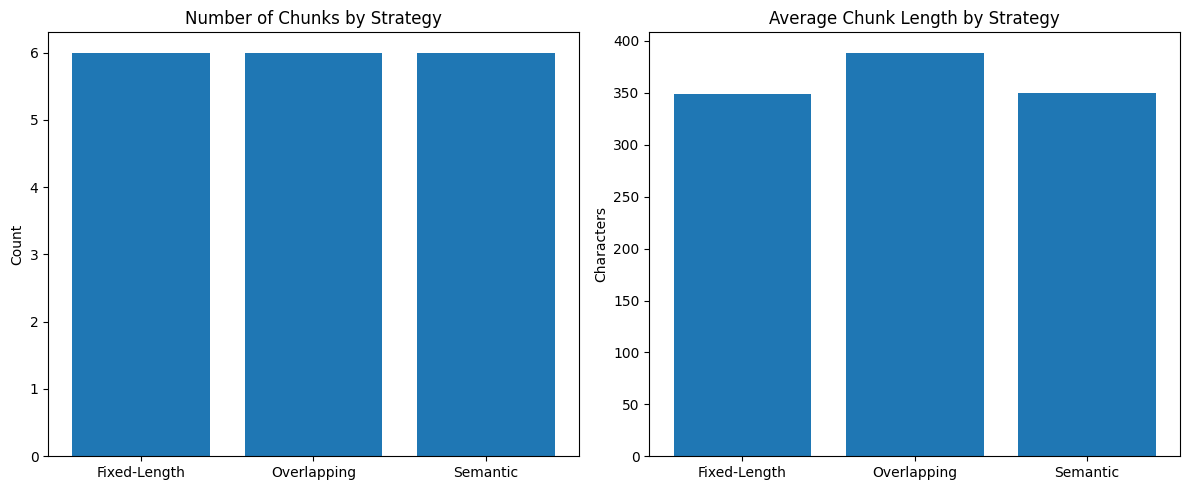

In [ ]:
chunking_comparison = pd.DataFrame({
    'Strategy': ['Fixed-Length', 'Overlapping', 'Semantic'],
    'Number of Chunks': [len(chunks_fixed), len(chunks_overlap), len(chunks_semantic)],
    'Average Chunk Length': [
        sum(len(chunk.text) for chunk in chunks_fixed) / len(chunks_fixed),
        sum(len(chunk.text) for chunk in chunks_overlap) / len(chunks_overlap),
        sum(len(chunk.text) for chunk in chunks_semantic) / len(chunks_semantic)
    ]
})

display(chunking_comparison)

# Visualize the comparison
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(chunking_comparison['Strategy'], chunking_comparison['Number of Chunks'])
plt.title('Number of Chunks by Strategy')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(chunking_comparison['Strategy'], chunking_comparison['Average Chunk Length'])
plt.title('Average Chunk Length by Strategy')
plt.ylabel('Characters')

plt.tight_layout()
plt.show()

## 3. Exploring Different Embedding Models

Embeddings convert text into numerical vectors. Let's explore different embedding models:

## ✅ What it’s doing:

1. Pick two models:
- MiniLM (smaller, 384 numbers per sentence).
- MPNet (bigger, 768 numbers per sentence).

2. Generate embeddings:
- It converts the sentence “Embeddings are numerical representations of text in vector space.” into a list of numbers (a vector).

3. Measure time:
- Record how long each model takes to do this.

4. Show results:
- Print a table with:
  - Model name
  - Embedding size (dimensions)
  - Time taken

📊 Why? → You’re benchmarking to see which model is faster and how many numbers it produces.

### 3.1 Hugging Face Embeddings

In [ ]:
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Initialize a list to store results
embedding_results = []

# Test different HuggingFace embedding models
hf_models = [
    "sentence-transformers/all-MiniLM-L6-v2",  # Small, fast model (384 dimensions)
    "sentence-transformers/all-mpnet-base-v2",  # More powerful (768 dimensions)
]

for model_name in hf_models:
    start_time = time.time()

    embed_model = HuggingFaceEmbedding(model_name=model_name)

    # Generate an embedding for a test sentence
    test_text = "Embeddings are numerical representations of text in vector space."
    embedding = embed_model.get_text_embedding(test_text)

    end_time = time.time()

    embedding_results.append({
        'Model': model_name,
        'Dimensions': len(embedding),
        'Generation Time (s)': end_time - start_time
    })

# Display results
embedding_df = pd.DataFrame(embedding_results)
display(embedding_df)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Model,Dimensions,Generation Time (s)
0,sentence-transformers/all-MiniLM-L6-v2,384,1.449325
1,sentence-transformers/all-mpnet-base-v2,768,9.044852


### 3.2 OpenAI Embeddings (Optional)

If you have an OpenAI API key, you can try their embeddings:

In [ ]:
# Uncomment if you have an OpenAI API key
'''
from llama_index.embeddings.openai import OpenAIEmbedding

start_time = time.time()

openai_embed_model = OpenAIEmbedding(model="text-embedding-3-small")
openai_embedding = openai_embed_model.get_text_embedding(test_text)

end_time = time.time()

embedding_results.append({
    'Model': 'OpenAI text-embedding-3-small',
    'Dimensions': len(openai_embedding),
    'Generation Time (s)': end_time - start_time
})

# Update results dataframe
embedding_df = pd.DataFrame(embedding_results)
display(embedding_df)
'''

'\nfrom llama_index.embeddings.openai import OpenAIEmbedding\n\nstart_time = time.time()\n\nopenai_embed_model = OpenAIEmbedding(model="text-embedding-3-small")\nopenai_embedding = openai_embed_model.get_text_embedding(test_text)\n\nend_time = time.time()\n\nembedding_results.append({\n    \'Model\': \'OpenAI text-embedding-3-small\',\n    \'Dimensions\': len(openai_embedding),\n    \'Generation Time (s)\': end_time - start_time\n})\n\n# Update results dataframe\nembedding_df = pd.DataFrame(embedding_results)\ndisplay(embedding_df)\n'

### 3.3 Visualizing Embedding Similarity

Let's visualize how different texts are related in embedding space:

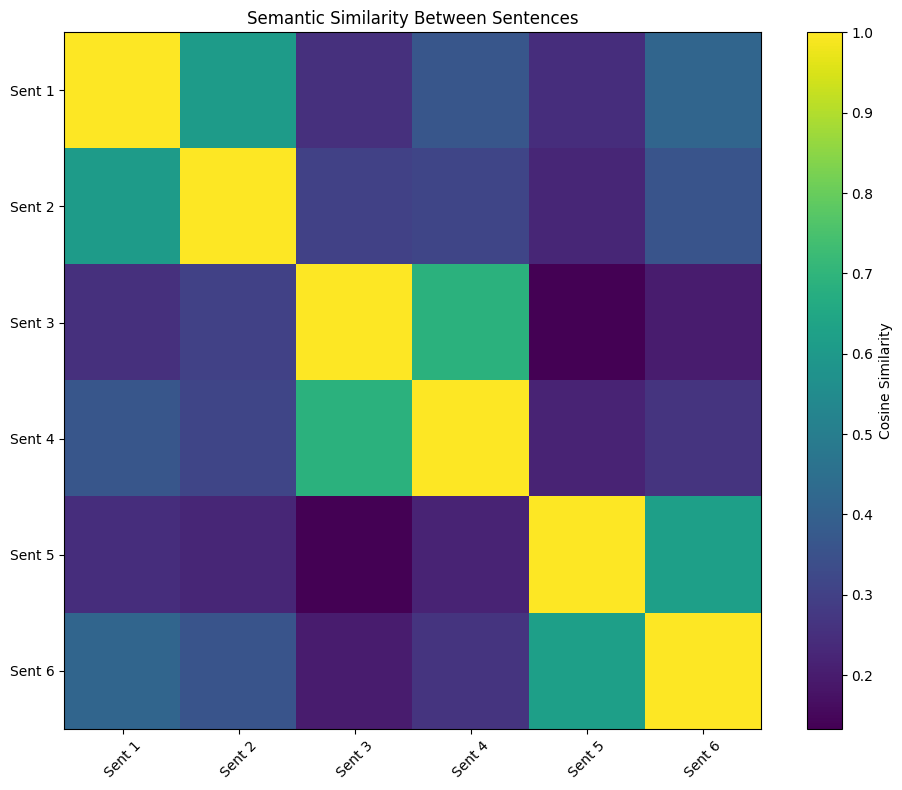

Sentence 1: Neural networks are a powerful machine learning technique.
Sentence 2: Deep learning models have many layers of neurons.
Sentence 3: Embeddings represent words or sentences as vectors.
Sentence 4: Vector representations help computers understand semantics.
Sentence 5: The history of AI begins in the 1950s.
Sentence 6: Artificial intelligence research has evolved over decades.


In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Define some test sentences
test_sentences = [
    "Neural networks are a powerful machine learning technique.",
    "Deep learning models have many layers of neurons.",
    "Embeddings represent words or sentences as vectors.",
    "Vector representations help computers understand semantics.",
    "The history of AI begins in the 1950s.",
    "Artificial intelligence research has evolved over decades."
]

# Create embeddings for each sentence
# all-MiniLM-L6-v2 is used as in the previous cell, that ran faster than all-mpnet-base-v2
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")
embeddings = [embed_model.get_text_embedding(sent) for sent in test_sentences]

# Calculate similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Visualize the similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='viridis')
plt.colorbar(label='Cosine Similarity')
plt.xticks(np.arange(len(test_sentences)), [f"Sent {i+1}" for i in range(len(test_sentences))], rotation=45)
plt.yticks(np.arange(len(test_sentences)), [f"Sent {i+1}" for i in range(len(test_sentences))])
plt.title('Semantic Similarity Between Sentences')
plt.tight_layout()
plt.show()

# Print the sentences for reference
for i, sent in enumerate(test_sentences):
    print(f"Sentence {i+1}: {sent}")

## 4. Building a Vector Store with LlamaIndex

Now, let's combine what we've learned to build a vector database:

## How vector databases & embeddings are connected?

1. Store phase (indexing):
- Each chunk of your document → embedding → stored in the vector DB along with metadata (like original text, doc ID).
- The DB now has thousands of vectors that represent your knowledge base.

    - Example (Chroma style):
    - Vector: [0.12, -0.48, ...]  
    - Metadata: "Early AI research focused on symbolic methods..."

2. Query phase (retrieval):
- User asks: “When did AI research begin?”
- The query is turned into an embedding vector.
- The vector DB compares it to all stored embeddings, finds the closest ones (semantic neighbors).
- Returns the top-k most relevant text chunks.

## ✅ What it is doing:

1. Each document chunk is converted into an embedding (a list of numbers). Those embeddings + their text are stored inside the Chroma collection.

2. The ChromaVectorStore wrapper makes Chroma behave like a plug-and-play “vector store” inside LlamaIndex.
- When you run a query later, LlamaIndex:
    - Turns your question into an embedding.
    - Asks the vector store: “Which stored vectors are closest to this query vector?”
    - Retrieves the most relevant text chunks.

##🔹 Why it matters
- Vector stores are the backbone of semantic search and RAG (retrieval-augmented generation).
- They let you go beyond keyword search.

- Query: “birth of AI”
- Stored text: “AI research began in the 1950s.”
- Even without the word “birth”, the vector store knows they’re related because the embeddings are close in meaning.

##🔹 Easy analogy
- Think of a vector store like Spotify for embeddings:
- Each song = an embedding (numbers describing melody, rhythm, mood).
- Vector store = the library that can recommend “songs that sound similar.”
- Instead of music similarity, you’re doing semantic similarity on text.

In [ ]:
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.vector_stores.chroma import ChromaVectorStore
import chromadb

# Initialize a Chroma client
chroma_client = chromadb.Client()
chroma_collection = chroma_client.create_collection("semantic_search_demo")

# Create vector store
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# Let's use overlapping chunks for our index
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create index
index = VectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,
    embed_model=embed_model
)

print("Vector store created successfully!")

Vector store created successfully!



## 5. Querying with Gemini

Finally, let's use Gemini to query our vector database:

## ✅ What it’s doing:

1. Initialize Gemini
- Loads Google’s Gemini 1.5-Flash model as the “answer generator.”
- Create a Query Engine
- Connects your index (Chroma vector store) with Gemini.
- Sets similarity_top_k = 2 → always fetch the top 2 most relevant chunks of text from your knowledge base for each query.

2. Define run_query function
- Takes a user’s question.
- Passes it to the query engine → which retrieves relevant chunks and asks Gemini to generate a response.
- Prints:
  - The final answer from Gemini.
  - The source chunks used, with similarity scores (so you know what info Gemini relied on).

3. Run sample queries
- Loops over 3 example questions.
- For each one:
    - Retrieves 2 chunks from Chroma.
    - Passes them + the question into Gemini.
    - Prints the answer and shows which text chunks were used as evidence.

📊 Why? → This cell is where your pipeline comes alive:
Retrieval (find chunks by meaning) + Generation (Gemini writes an answer) = Retrieval-Augmented Generation (RAG).

In [ ]:
from llama_index.llms.gemini import Gemini

# Initialize Gemini LLM
llm = Gemini(model="models/gemini-1.5-flash")

# Set up query engine with our custom components
query_engine = index.as_query_engine(
    llm=llm,
    similarity_top_k=2  # Retrieve top 2 most similar chunks
)

# Function to query and display results
def run_query(query_text):
    print(f"Query: {query_text}")
    print("-" * 50)

    # Get response
    response = query_engine.query(query_text)

    print("Response:")
    display(Markdown(response.response))

    print("\nSource Nodes:")
    for i, node in enumerate(response.source_nodes):
        print(f"\nSource {i+1} (Score: {node.score:.4f}):")
        print("-" * 40)
        print(node.text)

    return response

# Try different queries
queries = [
    "How did neural networks develop over time?",
    "What are embeddings and how are they used?",
    "Explain the history of artificial intelligence."
]

# Run each query
for query in queries:
    run_query(query)
    print("\n" + "="*80 + "\n")

/tmp/ipython-input-1028938175.py:4: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-1.5-flash")


Query: How did neural networks develop over time?
--------------------------------------------------
Response:


Early neural network models, such as the perceptron, emerged in the late 1950s.  Later developments led to the creation of networks with multiple interconnected layers of nodes, including deep neural networks with multiple hidden layers.  Specialized architectures like Convolutional Neural Networks were developed for image processing, while Recurrent Neural Networks and transformers were designed to handle sequential data.  The evolution of these networks is closely tied to the broader history of artificial intelligence, with significant advancements occurring alongside the rise of machine learning and deep learning.



Source Nodes:

Source 1 (Score: 0.5048):
----------------------------------------
Neural networks are computing systems inspired by biological neural networks.
The perceptron, developed by Frank Rosenblatt in 1958, was one of the earliest neural network models.
Modern neural networks consist of layers of interconnected nodes or "neurons."
Each connection can transmit a signal from one neuron to another.
The receiving neuron processes the signal and signals downstream neurons connected to it.
Deep neural networks contain multiple hidden layers between input and output layers.
Convolutional Neural Networks (CNNs) revolutionized image processing.
Recurrent Neural Networks (RNNs) and transformers handle sequential data like text or time series.

Source 2 (Score: 0.4195):
----------------------------------------
Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused 

Embeddings are dense vector representations of data, mapping similar items closer together in a continuous vector space.  This applies to words, sentences, and entire documents.  They facilitate semantic search, going beyond keyword matching to find conceptually similar items.  Furthermore, they are crucial for recommendation systems, clustering, and classification tasks.  Advanced models provide cutting-edge performance in these applications.



Source Nodes:

Source 1 (Score: 0.3920):
----------------------------------------
Embeddings are dense vector representations of data in a continuous vector space.
Word embeddings map words to vectors where similar words are positioned closer together.
Popular word embedding techniques include Word2Vec, GloVe, and FastText.
Sentence embeddings capture meaning at the sentence level rather than individual words.
Models like Universal Sentence Encoder and SBERT create powerful sentence embeddings.
Document embeddings represent entire documents as fixed-length vectors.
Embeddings enable semantic search by finding documents with similar meaning, not just keyword matches.
They also power recommendation systems, clustering, and classification tasks.
Recent models like OpenAI's text-embedding-ada and Cohere's embedding models offer state-of-the-art performance.

Source 2 (Score: 0.2302):
----------------------------------------
Neural networks are computing systems inspired by biological neur

Artificial intelligence's history began in the 1950s with the coining of the term at the Dartmouth Conference.  Early work concentrated on symbolic methods and rule-based systems.  Expert systems gained popularity in the 1980s, but had limitations.  The focus shifted toward machine learning in the 1990s and early 2000s.  A significant breakthrough in computer vision around 2012 marked the start of the deep learning revolution.  Currently, advanced AI capabilities are demonstrated by large language models capable of producing human-like text after being trained on extensive text data.



Source Nodes:

Source 1 (Score: 0.4939):
----------------------------------------
Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods and rule-based systems.
In the 1980s, expert systems became popular but faced limitations.
The 1990s and early 2000s saw a shift towards machine learning approaches.
The deep learning revolution began around 2012 with breakthrough results in computer vision.
Today, large language models like GPT, LLaMA, and Gemini represent cutting-edge AI capabilities.
These models are trained on vast amounts of text data and can generate human-like responses.

Source 2 (Score: 0.3131):
----------------------------------------
Neural networks are computing systems inspired by biological neural networks.
The perceptron, developed by Frank Rosenblatt in 1958, was one of the earliest neural network models.
Modern neural networ

## 6. Interactive Experiments

This section provides instructions and examples for hands-on experimentation with chunking and embedding techniques. Try these experiments to deepen your understanding.

### Experiment 1: Testing Different Chunking Parameters

Try modifying the chunking parameters to see how they affect the results:

In [ ]:
# EXPERIMENT: Test different chunk sizes and overlaps
# Try these combinations and compare the results:
# 1. Small chunks (100 tokens) with no overlap
# 2. Medium chunks (300 tokens) with small overlap (30 tokens)
# 3. Large chunks (500 tokens) with larger overlap (100 tokens)

# Example code to experiment with:
from llama_index.core.node_parser import SentenceSplitter

# Example 1: Small chunks, no overlap
splitter_small = SentenceSplitter(chunk_size=100, chunk_overlap=0)
chunks_small = splitter_small.get_nodes_from_documents(documents)
print(f"Small chunks: Created {len(chunks_small)} chunks")

# Example 2: Medium chunks with overlap
splitter_medium = SentenceSplitter(chunk_size=300, chunk_overlap=30)
chunks_medium = splitter_medium.get_nodes_from_documents(documents)
print(f"Medium chunks: Created {len(chunks_medium)} chunks")

# Example 3: Large chunks with larger overlap
splitter_large = SentenceSplitter(chunk_size=500, chunk_overlap=100)
chunks_large = splitter_large.get_nodes_from_documents(documents)
print(f"Large chunks: Created {len(chunks_large)} chunks")

# To inspect chunks, print a few examples:
def inspect_chunks(chunks, name):
    print(f"\n--- First chunk from {name} ---")
    print(chunks[0].text[:200] + "...")  # Show first 200 chars of first chunk
    if len(chunks) > 1:
        print(f"\n--- Second chunk from {name} ---")
        print(chunks[1].text[:200] + "...")  # Show first 200 chars of second chunk

# Inspect samples from each chunking strategy
inspect_chunks(chunks_small, "small chunks")
inspect_chunks(chunks_medium, "medium chunks")
inspect_chunks(chunks_large, "large chunks")

Small chunks: Created 6 chunks
Medium chunks: Created 3 chunks
Large chunks: Created 3 chunks

--- First chunk from small chunks ---
Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods ...

--- Second chunk from small chunks ---
The deep learning revolution began around 2012 with breakthrough results in computer vision.
Today, large language models like GPT, LLaMA, and Gemini represent cutting-edge AI capabilities.
These mode...

--- First chunk from medium chunks ---
Artificial Intelligence (AI) has a rich history dating back to the 1950s.
The term was first coined by John McCarthy in 1956 at the Dartmouth Conference.
Early AI research focused on symbolic methods ...

--- Second chunk from medium chunks ---
Embeddings are dense vector representations of data in a continuous vector space.
Word embeddings map words to vectors where similar w

**Questions to consider:**
- How does changing chunk size affect the total number of chunks?
- What happens to semantic coherence as you decrease chunk size?
- How does overlap help maintain context between chunks?


### Experiment 2: Comparing Embedding Similarities

Explore how different texts are related in embedding space:

In [ ]:
# EXPERIMENT: Compare embedding similarities between different texts
# Try creating embeddings for different sentence pairs and see how
# the similarity scores change based on semantic meaning

import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# Initialize embedding model
embed_model = HuggingFaceEmbedding(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Define pairs of sentences to compare
sentence_pairs = [
    # Similar topic, similar wording
    ("Neural networks process data through interconnected nodes.",
     "Neural networks analyze information using connected neurons."),

    # Similar topic, different wording
    ("Embeddings transform text into vectors.",
     "Vector representations capture the semantic meaning of words."),

    # Different topics
    ("Neural networks are used in image recognition.",
     "Embeddings are used for semantic search."),

    # Try your own pairs!
    ("I love cats and dogs.",
     "Volunteering at animal shelters give me so much peace and happiness."),

    ("I am from Singapore.",
     "Singapore is a country just 1 degree north of the equator."),

    ("Cats and dogs provide unconditional love.",
     "Singapore is a country just 1 degree north of the equator.")
]

# Calculate similarity for each pair
for i, (sent1, sent2) in enumerate(sentence_pairs):
    # Get embeddings
    emb1 = embed_model.get_text_embedding(sent1)
    emb2 = embed_model.get_text_embedding(sent2)

    # Calculate similarity
    similarity = cosine_similarity([emb1], [emb2])[0][0]

    # Print results
    print(f"\nPair {i+1}:")
    print(f"Sentence 1: {sent1}")
    print(f"Sentence 2: {sent2}")
    print(f"Similarity Score: {similarity:.4f}")


Pair 1:
Sentence 1: Neural networks process data through interconnected nodes.
Sentence 2: Neural networks analyze information using connected neurons.
Similarity Score: 0.6275

Pair 2:
Sentence 1: Embeddings transform text into vectors.
Sentence 2: Vector representations capture the semantic meaning of words.
Similarity Score: 0.6206

Pair 3:
Sentence 1: Neural networks are used in image recognition.
Sentence 2: Embeddings are used for semantic search.
Similarity Score: 0.3161

Pair 4:
Sentence 1: I love cats and dogs.
Sentence 2: Volunteering at animal shelters give me so much peace and happiness.
Similarity Score: 0.4236

Pair 5:
Sentence 1: I am from Singapore.
Sentence 2: Singapore is a country just 1 degree north of the equator.
Similarity Score: 0.5229

Pair 6:
Sentence 1: Cats and dogs provide unconditional love.
Sentence 2: Singapore is a country just 1 degree north of the equator.
Similarity Score: -0.0216


**Questions to consider:**
- What similarity threshold would you use to consider two sentences as related?
- How does word choice affect similarity even when the meaning is similar?
- What happens if you try different embedding models?



### Experiment 3: Custom Querying with Different Parameters

Modify query parameters to see how they affect retrieval results:

In [ ]:
# EXPERIMENT: Test different query parameters and analyze results
# Try different values for top_k and observe how it affects
# the relevance of retrieved chunks

from llama_index.llms.gemini import Gemini

# Initialize Gemini LLM
llm = Gemini(model="models/gemini-1.5-flash")

# Sample queries to test
test_queries = [
    "What are neural networks?",
    "How have embeddings evolved over time?",
    "Describe the history of AI development.",
    # Add your own queries here!
    "What is an embedding?",
    "How was AI used in the past?"
]

# Try different top_k values
top_k_values = [1, 2, 4]

# Function to run a query with a specific top_k
def test_query(query_text, top_k):
    # Set up query engine
    query_engine = index.as_query_engine(
        llm=llm,
        similarity_top_k=top_k
    )

    # Get response
    response = query_engine.query(query_text)

    print(f"\nQuery: {query_text}")
    print(f"Using top_k = {top_k}")
    print("-" * 50)
    print(f"Response: {response.response[:200]}...")  # First 200 chars

    print(f"\nRetrieved {len(response.source_nodes)} source nodes:")
    for i, node in enumerate(response.source_nodes):
        print(f"  Source {i+1} (Score: {node.score:.4f}): {node.text[:100]}...")

    return response



/tmp/ipython-input-3371335666.py:8: DeprecationWarning: Call to deprecated class Gemini. (Should use `llama-index-llms-google-genai` instead, using Google's latest unified SDK. See: https://docs.llamaindex.ai/en/stable/examples/llm/google_genai/)
  llm = Gemini(model="models/gemini-1.5-flash")


In [ ]:
# Example usage:
# Choose a query from test_queries and a top_k value to experiment with
test_query(test_queries[0], top_k=1)


Query: What are neural networks?
Using top_k = 1
--------------------------------------------------
Response: Neural networks are computing systems modeled after biological neural networks.  They're composed of interconnected nodes, or neurons, arranged in layers.  Signals are transmitted between these nodes,...

Retrieved 1 source nodes:
  Source 1 (Score: 0.6201): Neural networks are computing systems inspired by biological neural networks.
The perceptron, develo...


Response(response="Neural networks are computing systems modeled after biological neural networks.  They're composed of interconnected nodes, or neurons, arranged in layers.  Signals are transmitted between these nodes, with each receiving neuron processing the signal and potentially transmitting it further.  Different types exist, including those with multiple hidden layers (deep neural networks), those specialized for image processing (Convolutional Neural Networks), and those designed for sequential data (Recurrent Neural Networks and transformers).  One early example is the perceptron, created in 1958.\n", source_nodes=[NodeWithScore(node=TextNode(id_='8a6a04cc-5e80-4dfd-b8a1-5b6c9efdb5aa', embedding=None, metadata={'file_path': '/content/sample_docs/neural_networks.txt', 'file_name': 'neural_networks.txt', 'file_type': 'text/plain', 'file_size': 668, 'creation_date': '2025-09-19', 'last_modified_date': '2025-09-19'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_si

**Questions to consider:**
- How does increasing top_k affect response quality?
- Is there a point where adding more chunks decreases answer quality?
- How do different chunking strategies affect the retrieval results?

### Experiment 4: Comparing Different Embedding Models

Compare the performance of different embedding models:

In [ ]:
# EXPERIMENT: Compare different embedding models
# See how model choice affects similarity calculations and retrieval

from llama_index.embeddings.huggingface import HuggingFaceEmbedding
import time

# Define embedding models to test
embedding_models = [
    "sentence-transformers/all-MiniLM-L6-v2",  # Small, fast model (384 dimensions)
    "sentence-transformers/all-mpnet-base-v2",  # More powerful (768 dimensions)
    # Add other models if desired
]

# Test text
test_text = "Embeddings transform words into numerical vectors that capture meaning."

# Compare models
for model_name in embedding_models:
    print(f"\nTesting model: {model_name}")

    # Time the embedding generation
    start_time = time.time()
    embed_model = HuggingFaceEmbedding(model_name=model_name)
    embedding = embed_model.get_text_embedding(test_text)
    end_time = time.time()

    # Print results
    print(f"Dimensions: {len(embedding)}")
    print(f"First 5 values: {embedding[:5]}")
    print(f"Generation time: {end_time - start_time:.4f} seconds")

# Optional: Create a simple index with different embedding models and compare
# the retrieval results for the same query


Testing model: sentence-transformers/all-MiniLM-L6-v2
Dimensions: 384
First 5 values: [-0.0011335837189108133, -0.030347218737006187, 0.051215894520282745, -0.036967843770980835, 0.0163107942789793]
Generation time: 1.4852 seconds

Testing model: sentence-transformers/all-mpnet-base-v2
Dimensions: 768
First 5 values: [-0.04178156703710556, 0.061772800981998444, -0.012062777765095234, 0.045359380543231964, 0.022207118570804596]
Generation time: 1.8534 seconds


**Questions to consider:**
- How does embedding dimension affect performance and quality?
- Is the additional computation time for larger models worth the quality improvement?
- Which model would you choose for a production application and why?

## Key Takeaways

1. **Chunking Strategies**:
   - Fixed-length chunking is simple but may break semantic coherence
   - Overlapping chunks help maintain context across boundaries
   - Semantic chunking preserves meaning-based segments but is more resource-intensive

2. **Embedding Models**:
   - Different models offer varying dimensions and performance characteristics
   - Larger models typically provide better semantic understanding but are slower
   - Domain-specific models can outperform generic ones for specialized tasks

3. **Retrieval Performance**:
   - The choice of chunking and embedding strategy significantly impacts retrieval quality
   - Tuning parameters like chunk size, overlap, and top_k affects results
   - The best approach depends on your specific documents and use case

4. **LlamaIndex + Gemini Integration**:
   - Combining LlamaIndex's retrieval capabilities with Gemini's language capabilities creates powerful RAG systems
   - This modular approach lets you optimize each component separately

### Next Steps:

- Try different chunking strategies on your own documents
- Experiment with domain-specific embedding models
- Explore advanced retrievers like hierarchical or hybrid retrievers
- Fine-tune the system by adjusting response synthesis settings